# Load data from the excel file:



In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt


# Load data from excel
data = pd.read_excel('temp_with_anomalies_ds.xlsx')

# Display the data
print(data.head())

                     time  temperature_value sensor_type
0 2023-05-02 08:01:42.885              25.37     ds18b20
1 2023-05-02 08:01:44.658              25.37     ds18b20
2 2023-05-02 08:01:46.436              25.37     ds18b20
3 2023-05-02 08:01:48.215              25.37     ds18b20
4 2023-05-02 08:01:49.996              25.37     ds18b20


# Time Series Initialization algorithm:

The algorithm takes an original time series (TS) and two integers m and n as input and returns a new initialized time series (ITS).

m is the number of most common values to be selected from the original series, and n is the number of times each of these values should be repeated. These values ensure that the initial segment of the series (of length m times n) is without any anomaly.


1. Choosing m: This represents the number of the most frequent values to consider. If your sensor data is mostly regular and you're trying to detect anomalies, you would want m to be small. This is because you're primarily interested in the most common, regular values, and less interested in the less common values, which might include anomalies. On the other hand, if your data has a lot of variability, you might want to increase m to ensure you're capturing the main patterns in the data.

2. Choosing n: This represents the number of times each of the m most frequent values is repeated in the initialization phase of the algorithm. If the repeated sequence is used to create a "baseline" or "normal" pattern against which to compare the actual sensor data, you might want n to be large. This would give your algorithm a substantial amount of "normal" data to learn from before it starts seeing the actual sensor data. However, if the initialization sequence is not meant to represent "normal" data, or if the sensor data is very large, you might want to keep n small to avoid making the initialization sequence overly large.

In both cases, we tried out different values of m and n and evaluated the performance of our anomaly detection algorithm using evaluation metrics. Over time, we found that certain values of m and n work better for your specific use case.

This initialization ensures that the initial values of the mean and variance calculated over the first m*n data points in the resulting series are not affected by any potential anomalies. This is because the initialization only uses the most frequently occurring numbers, which are presumably representative of "normal" behavior, not anomalous behavior.

If the anomaly detection system calculates a moving average or moving variance over a lag of m*n data points, then for the first m*n data points, these calculations will be based solely on "normal" data. This can provide a stable baseline against which to compare the rest of the data, and it can prevent the detection system from being "influenced" or skewed by any potential anomalies at the very beginning of the actual data.


However, this approach assumes that the most frequent values are indeed representative of "normal" behavior and that any anomalies would be less frequent. We believe that this is a valid assumption because of the nature of the data we collected and the type of anomalies we're trying to detect, aka abnormal behavior.

In [2]:
def initialize_series(TS, m, n):
    # Phase a: Identify the m most frequent numbers and repeat each n times
    number_counts = Counter(TS)  # Count the occurrences of each number in TS
    most_frequent_numbers = [num for num, _ in number_counts.most_common(m)]  # Get the m most frequent numbers

    # Create a list of the m most frequent numbers, each repeated n times
    ITS = [num for num in most_frequent_numbers for _ in range(n)]
    
    # print the list of the m most frequent numbers, each repeated n times
    print(ITS)
    
    # Phase b: Randomly assort the m*n numbers
    np.random.shuffle(ITS)

    # Concatenate the initialized series with the original time series
    ITS.extend(TS)

    return ITS

In [23]:
TS = data['temperature_value']

m=10
n=3 

ITS = initialize_series(TS,m, n)

[24.89, 24.89, 24.89, 23.91, 23.91, 23.91, 25.86, 25.86, 25.86, 23.42, 23.42, 23.42, 26.35, 26.35, 26.35, 25.38, 25.38, 25.38, 25.44, 25.44, 25.44, 25.37, 25.37, 25.37, 24.75, 24.75, 24.75, 24.4, 24.4, 24.4]


# Smoothed Z-score algorithm

The lag is a parameter that determines how many of the preceding data points should be considered for calculating the mean and standard deviation. A larger lag means the algorithm takes more past values into account, which makes the prediction more robust to recent anomalies but also less responsive to sudden, large changes.

The S_threshold is a measure of how many standard deviations away from the mean a data point needs to be in order to be considered an anomaly. A larger S_threshold means only very large deviations from the mean will be considered anomalies, which makes the algorithm less sensitive but also more specific.

In [24]:
def smoothed_z_score(ITS, lag, threshold):
    # Step 1: Predict the value of point i+1, the next point of point i, according to the set lag: lag = n*m
    # To do this, calculate the moving average of the initialized time series (ITS) with a window size equal to the lag
    # Note: 'valid' mode in np.convolve means that the convolution is only computed where the input and the filter fully overlap
    moving_avg = np.convolve(ITS, np.ones(lag), 'valid') / lag

    # Also calculate the moving standard deviation with a window size equal to the lag
    # This represents the variability or dispersion of the time series data within the lag window
    moving_std = np.array([np.std(ITS[i-lag+1:i+1]) for i in range(lag-1, len(ITS))])

    # Step 2: Calculate the data range that would be considered acceptable
    # This is calculated as the moving standard deviation multiplied by the threshold
    # The threshold represents how many standard deviations away from the moving average a value must be to be considered an anomaly
    acceptable_range = moving_std * threshold

    # Extend moving_avg, moving_std and acceptable_range arrays for calculation
    # Fill the first (lag - 1) positions with NaNs to match the size of the ITS
    moving_avg = np.concatenate((np.array([np.nan] * (lag-1)), moving_avg))
    moving_std = np.concatenate((np.array([np.nan] * (lag-1)), moving_std))
    acceptable_range = np.concatenate((np.array([np.nan] * (lag-1)), acceptable_range))

    # Step 3: Calculate the difference between actual value and predicted value for each point
    # The predicted value is represented by the moving average
    diff = ITS - moving_avg

    # Initialize an array to hold the anomaly detection results, or 'signals', for each data point
    # Start with an array of zeros, then update this as we identify anomalies
    signals = np.zeros(len(ITS))

    # Step 4: Calculate the anomaly detection result for each data point
    # If the absolute value of the difference exceeds the acceptable range, it is considered an anomaly
    # We assign a 'signal' of 1 or -1, depending on whether the actual value is greater than or less than the predicted value
    signals[np.abs(diff) > acceptable_range] = np.sign(diff[np.abs(diff) > acceptable_range])

    # Step 5: For signals that are not zero (anomalies), smooth the value by setting it to the previous value
    # This can help to reduce the impact of anomalous values on the further analysis
    for i in range(1, len(ITS)):
        if signals[i] == 0:
            ITS[i] = ITS[i-1]

    # The function returns the smoothed time series and the anomaly signals
    return ITS, signals

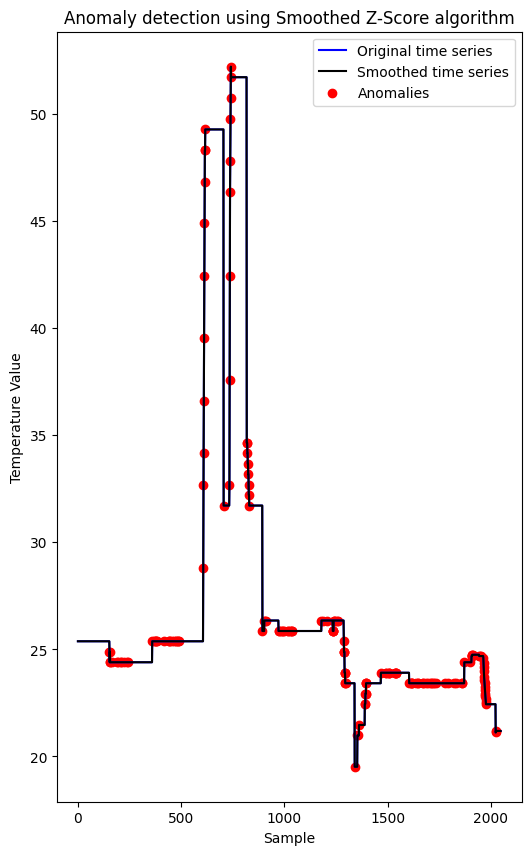

In [25]:
lag = n*m
threshold = 2

# Detect anomalies
ITS_smoothed, anomaly_signals = smoothed_z_score(ITS, lag, threshold)
# Make the plot
plt.figure(figsize=(6, 10))

# Plot the original time series
plt.plot(ITS, color='blue', label='Original time series')
plt.plot(ITS_smoothed, color='black', label='Smoothed time series')

# Plot the anomaly signals
anomalies = np.array(ITS)[np.abs(np.array(anomaly_signals)) > 0]
anomalies_indices = np.argwhere(np.abs(np.array(anomaly_signals)) > 0).flatten()

plt.scatter(anomalies_indices, anomalies, color='red', label='Anomalies')

plt.title('Anomaly detection using Smoothed Z-Score algorithm on data from Dallas')
plt.xlabel('Sample')
plt.ylabel('Temperature Value')
plt.legend()
plt.show()


# Evaluation metrics for the anomaly detection algorithm  


NR is the number of real anomaly points -- need to label my data

AR is abnormal rate

NP is the total number of points

ND is the number of anomaly points detected

ACC is the accuracy 

Accuracy is the ratio of points detected correctly (including anomaly points which were detected as abnormal, and normal points which were not detected as abnormal) to the total number of points.

ACC = NDC / NP where NDC is the number of points detected correctly, NP is the total number of points

In [34]:
def calculate_metrics(ITS_smoothed, anomaly_signals):
    # Total number of points
    NP = len(ITS_smoothed)

    # Number of real anomaly points (as detected by the algorithm)
    NR = len(anomaly_signals[anomaly_signals != 0])
    
    # Anomaly Rate (AR)
    AR = NR / NP

    # Number of points detected correctly
    NDC = NP - NR

    # Accuracy (ACC)
    ACC = NDC / NP
    
    return {"Anomaly Ratio (AR): " : AR, "Accuracy (ACC): " : ACC, 
            "Total number of points (NP): ":NP, "Number of points detected correctly (NDC): ":NDC}


In [38]:
# calculate_metrics(ITS_smoothed, anomaly_signals)




# Evaluating the algorithm on LM35 Data

In [40]:
data_lm = pd.read_excel('temp_with_anomalies_lm.xlsx')
TS_lm = data_lm['temperature_value']

m=10
n=3 

ITS_lm = initialize_series(TS_lm,m, n)

[26.25, 26.25, 26.25, 25.81, 25.81, 25.81, 24.62, 24.62, 24.62, 26.31, 26.31, 26.31, 25.94, 25.94, 25.94, 25.87, 25.87, 25.87, 24.89, 24.89, 24.89, 25.75, 25.75, 25.75, 25.62, 25.62, 25.62, 23.91, 23.91, 23.91]


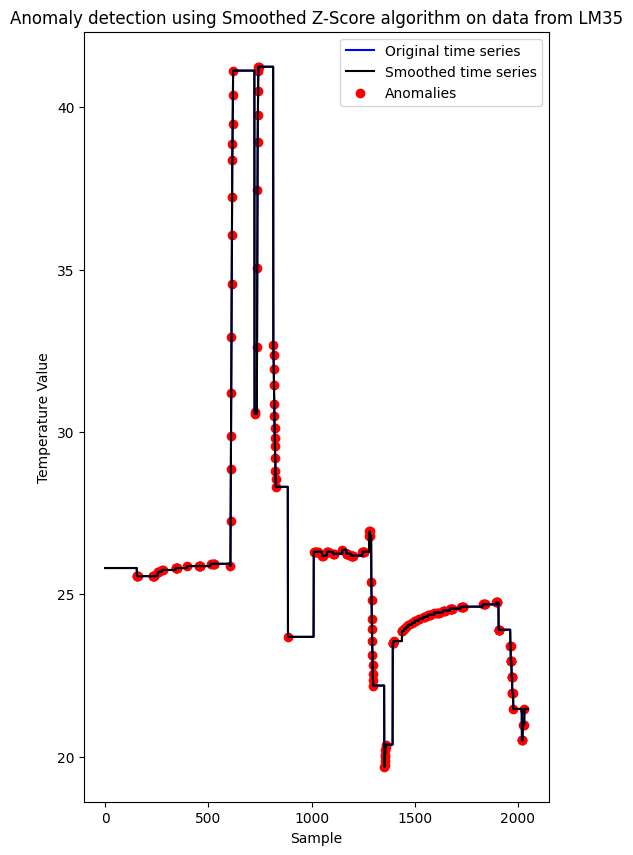

In [41]:
lag = n*m
threshold = 2

# Detect anomalies
ITS_smoothed_lm, anomaly_signals_lm = smoothed_z_score(ITS_lm, lag, threshold)
# Make the plot
plt.figure(figsize=(6, 10))

# Plot the original time series
plt.plot(ITS_lm, color='blue', label='Original time series')
plt.plot(ITS_smoothed_lm, color='black', label='Smoothed time series')

# Plot the anomaly signals
anomalies_lm = np.array(ITS_lm)[np.abs(np.array(anomaly_signals_lm)) > 0]
anomalies_indices_lm = np.argwhere(np.abs(np.array(anomaly_signals_lm)) > 0).flatten()

plt.scatter(anomalies_indices_lm, anomalies_lm, color='red', label='Anomalies')

plt.title('Anomaly detection using Smoothed Z-Score algorithm on data from LM35')
plt.xlabel('Sample')
plt.ylabel('Temperature Value')
plt.legend()
plt.show()
